In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pos_rev = pd.read_csv("Data\pos.txt", sep = "\n", header = None, encoding = 'latin-1')
pos_rev = pd.concat([pos_rev,pd.Series(np.ones(pos_rev.shape[0]))], ignore_index=True, axis =1)

In [4]:
pos_rev.columns = ['review', 'mood']
pos_rev.head()

,review,mood
0,the rock is destined to be the 21st century's ...,1.0
1,"the gorgeously elaborate continuation of "" the...",1.0
2,effective but too-tepid biopic,1.0
3,if you sometimes like to go to the movies to h...,1.0
4,"emerges as something rare , an issue movie tha...",1.0


In [5]:
neg_rev = pd.read_csv("Data//negative.txt", sep = "\n", header = None, encoding = 'latin-1')
neg_rev = pd.concat([neg_rev,pd.Series(np.zeros(pos_rev.shape[0]))], ignore_index=True, axis =1)
neg_rev.columns = ['review', 'mood']
neg_rev.head()

,review,mood
0,"simplistic , silly and tedious.",0.0
1,"it's so laddish and juvenile , only teenage bo...",0.0
2,exploitative and largely devoid of the depth o...,0.0
3,[garbus] discards the potential for pathologic...,0.0
4,a visually flashy but narratively opaque and e...,0.0


## Performing preprocessing on positive reviews

In [6]:
pos_rev.loc[:, 'review'] = pos_rev.loc[:, 'review'].apply(lambda x: x.lower())
pos_rev.loc[:, 'review'] = pos_rev.loc[:, 'review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

## Performing preprocessing on Negative reviews

In [7]:
neg_rev.loc[:, 'review'] = neg_rev.loc[:, 'review'].apply(lambda x: x.lower())
neg_rev.loc[:, 'review'] = neg_rev.loc[:, 'review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

### Combining the two for tokenization

In [8]:
com_rev = pd.concat([pos_rev, neg_rev], axis =0).reset_index()


In [9]:
com_rev.head()

,index,review,mood
0,0,the rock is destined to be the 21st centurys n...,1.0
1,1,the gorgeously elaborate continuation of the ...,1.0
2,2,effective but tootepid biopic,1.0
3,3,if you sometimes like to go to the movies to h...,1.0
4,4,emerges as something rare an issue movie that...,1.0


### Tokenization

In [10]:
max_features = 2000
tokenizer = Tokenizer(num_words = max_features, split=' ')
tokenizer.fit_on_texts(com_rev.loc[:, 'review'].values)
X = tokenizer.texts_to_sequences(com_rev.loc[:, 'review'].values)
X = pad_sequences(X)


In [11]:
X

array([[   0,    0,    0, ..., 1631,   38,  873],
       [   0,    0,    0, ...,  642,    4, 1236],
       [   0,    0,    0, ...,  671,   12, 1902],
       ...,
       [   0,    0,    0, ..., 1701, 1939,    4],
       [   0,    0,    0, ...,  405,   27,    2],
       [   0,    0,    0, ..., 1036,    3,   41]])

## Composing the LSTM Network

In [12]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 46, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 46, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [105]:
Y = pd.get_dummies(com_rev['mood']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7143, 46) (7143, 2)
(3519, 46) (3519, 2)


# batch size and epoch
The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.

Think of a batch as a for-loop iterating over one or more samples and making predictions. At the end of the batch, the predictions are compared to the expected output variables and an error is calculated. From this error, the update algorithm is used to improve the model, e.g. move down along the error gradient.

### Batch Gradient Descent. Batch Size = Size of Training Set
### Stochastic Gradient Descent. Batch Size = 1
### Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set

In [77]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 2)

C:\Users\kesha\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
 - 26s - loss: 0.6412 - accuracy: 0.6207
Epoch 2/15
 - 24s - loss: 0.4997 - accuracy: 0.7638
Epoch 3/15
 - 23s - loss: 0.4175 - accuracy: 0.8100
Epoch 4/15
 - 24s - loss: 0.3698 - accuracy: 0.8355
Epoch 5/15
 - 22s - loss: 0.3250 - accuracy: 0.8587
Epoch 6/15
 - 22s - loss: 0.2942 - accuracy: 0.8725
Epoch 7/15
 - 22s - loss: 0.2574 - accuracy: 0.8904
Epoch 8/15
 - 22s - loss: 0.2250 - accuracy: 0.9058
Epoch 9/15
 - 22s - loss: 0.2036 - accuracy: 0.9143
Epoch 10/15
 - 23s - loss: 0.1816 - accuracy: 0.9251
Epoch 11/15
 - 24s - loss: 0.1574 - accuracy: 0.9355
Epoch 12/15
 - 23s - loss: 0.1515 - accuracy: 0.9387
Epoch 13/15
 - 23s - loss: 0.1388 - accuracy: 0.9443
Epoch 14/15
 - 23s - loss: 0.1256 - accuracy: 0.9516
Epoch 15/15
 - 24s - loss: 0.1157 - accuracy: 0.9548


In [78]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 1.38
acc: 0.69


In [79]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")



pos_acc 63.6482939632546 %
neg_acc 77.23577235772358 %


(-1.1070098520919005,
 1.1587103009330155,
 -1.1091175412519303,
 1.1795282212743137)

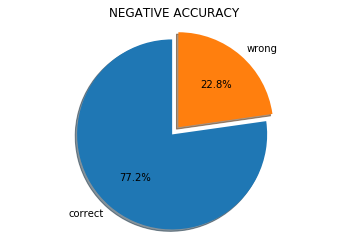

In [84]:
label = ['correct', 'wrong']
positve_acc = [neg_correct/neg_cnt*100, 100-(neg_correct/neg_cnt*100)]
explode = (0,0.1)

fig1, ax1 = plt.subplots()
plt.title('NEGATIVE ACCURACY')
ax1.pie(positve_acc, explode=explode, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 


# let's test the model for a review

In [111]:
Review= "The things this movie tries to get the audience to buy just won’t fly with most intelligent viewers." 


In [112]:
rev = tokenizer.texts_to_sequences(Review)
rev = pad_sequences(rev, maxlen=46, dtype='int32', value =0)
sentiment = model.predict(rev,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

positive


## USING SVM FOR SENTIMENT ANALYSIS

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(com_rev['review'].values,com_rev['mood'].values, test_size = 0.33, random_state = 42)

In [14]:
train_data = pd.DataFrame({'review':X_train, 'mood':Y_train})
test_data = pd.DataFrame({'review':X_test, 'mood':Y_test})

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform(train_data['review'])
test_vectors = vectorizer.transform(test_data['review'])

In [16]:
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(train_vectors, train_data['mood'])
prediction_linear = classifier_linear.predict(test_vectors)

In [17]:
report = classification_report(test_data['mood'], prediction_linear, output_dict=True)
print('positive:', report['1.0']['precision'])
print('negative:', report['0.0']['precision'])

positive: 0.7567412507171544
negative: 0.7415540540540541


NameError: name 'label' is not defined

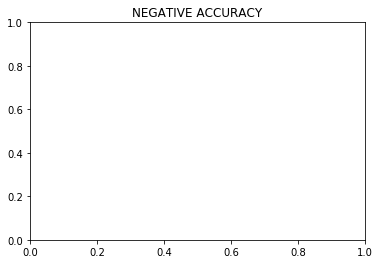

In [18]:
positve_acc = [report['0.0']['precision']*100, (1-report['0.0']['precision'])*100]
explode = (0,0.1)

fig1, ax1 = plt.subplots()
plt.title('NEGATIVE ACCURACY')
ax1.pie(positve_acc, explode=explode, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 


In [100]:
rev = [ "Although life or something like it is very much in the mold of feel good movies, the cast and director stephen herek’s polished direction pour delightfully piquant wine from aged bottles." ]

In [101]:
rev_vec = vectorizer.transform(rev)
if classifier_linear.predict(rev_vec) == 0.0:
    print('negative')
else:
    print('positive')

positive
